In [1]:
import os
import pandas as pd
import numpy as np
from torchsummary import summary
from utilities import *
from TaylorNet import *

/home/viet/anaconda3/envs/torch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
COL_NAMES = {'CelebA': {'dim_0': 'Hair Length',
                        'dim_1': 'Background Brightness',
                        'dim_3': 'Skin Tone',
                        'dim_4': 'Head Shape',
                        'dim_5': 'Hair Color',
                        'dim_6': 'Shadow',
                        'dim_7': 'Hair Azimuth',
                        'dim_8': 'Face Azimuth',
                        'dim_9': 'Hair Fringe'},
             'airbnb': {'amenities': 'Amenities',
                        'host_information': 'Host',
                        'listing_information': 'Listing',
                        'listing_review': 'Review',
                        'property_description': 'Property',
                        'property_location': 'Location'}}

In [3]:
# select dataset
data_name = 'CelebA'

In [4]:
if data_name == 'CelebA':
    from image_experiment import *
    train, val, test, target, features = get_datasets(data_name)
    concept_names = features
elif data_name == 'airbnb':
    from tabular_experiment import *
    train, val, test, target, features, concept_groups, concept_names = get_datasets(data_name)

In [5]:
# set device
device = torch.device("cuda", 0)

# define model
model = TaylorNet(len(concept_groups) if data_name == 'airbnb' else len(features),
                  DATASETS[data_name]['num_classes'],
                  concept_groups=concept_groups if data_name == 'airbnb' else None,
                  input_layer='linear',
                  hidden_dims=[64, 64, 32],
                  order=2,
                  rank=8,
                  initial='Taylor',
                  batchnorm=True,
                  concept_dropout=0.1,
                  encode_concepts=True if data_name == 'airbnb' else False,
                  output_penalty=0.0).to(device)

criterion = DATASETS[data_name]['criterion']

In [6]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Fast_Tucker_Taylor: 1-1                --
|    └─ParameterList: 2-1                32
|    └─ParameterList: 2-2                216
|    └─ParameterList: 2-3                576
Total params: 824
Trainable params: 824
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Fast_Tucker_Taylor: 1-1                --
|    └─ParameterList: 2-1                32
|    └─ParameterList: 2-2                216
|    └─ParameterList: 2-3                576
Total params: 824
Trainable params: 824
Non-trainable params: 0

In [7]:
model.load_state_dict(torch.load('figures/' + data_name + '_taylor2_model_plot.pt'))
train_loader = DataLoader(train, batch_size=1024, shuffle=True, num_workers=16)
test_loader = DataLoader(test, batch_size=1024, shuffle=False, num_workers=16)

In [8]:
# compute test results
_, ground_truths, predicted_results, concept_results = test_epoch(0, test_loader, train_loader, model, criterion, device)


Test set: Average loss: 0.5065	F1: 0.7347	Acc: 0.7575



In [9]:
# reconstruct taylor series
expression, weights, symbols = reconstruct_taylor(model.taylor_layers)

[torch.Size([2]), torch.Size([2, 9]), torch.Size([2, 9, 9])]
Matrix([[-0.45*z_1 + 0.15*z_2 + 0.92*z_3 - 0.11*z_4 - 0.26*z_5 - 0.07*z_6 - 0.83*z_7 - 0.11*z_8 - 0.28*z_9], [-0.08*z_1 + 0.2*z_2 + 0.1*z_3 + 0.06*z_4 - 0.05*z_5 - 0.07*z_6 - 0.18*z_7 - 0.16*z_8 - 0.15*z_9]])
Matrix([[0.05*z_1**2 + 0.13*z_1*z_2 + 0.13*z_1*z_3 - 0.05*z_1*z_4 - 0.04*z_1*z_5 + 0.03*z_1*z_6 + 0.01*z_1*z_7 - 0.02*z_1*z_9 + 0.16*z_2**2 + 0.02*z_2*z_3 - 0.09*z_2*z_4 - 0.2*z_2*z_5 + 0.01*z_2*z_6 + 0.02*z_2*z_7 + 0.02*z_2*z_8 - 0.07*z_2*z_9 + 0.05*z_3**2 - 0.e-2*z_3*z_4 + 0.1*z_3*z_5 + 0.03*z_3*z_6 + 0.07*z_3*z_7 + 0.01*z_3*z_8 + 0.04*z_3*z_9 + 0.09*z_4*z_5 - 0.08*z_4*z_7 + 0.01*z_4*z_8 - 0.02*z_4*z_9 - 0.12*z_5**2 + 0.03*z_5*z_6 + 0.04*z_5*z_7 + 0.01*z_5*z_8 - 0.03*z_6**2 - 0.01*z_6*z_7 - 0.06*z_6*z_8 + 0.08*z_7**2 + 0.02*z_7*z_8 + 0.07*z_7*z_9 - 0.e-2*z_8**2 - 0.01*z_8*z_9], [-0.05*z_1**2 - 0.13*z_1*z_2 - 0.13*z_1*z_3 + 0.05*z_1*z_4 + 0.04*z_1*z_5 - 0.03*z_1*z_6 - 0.e-2*z_1*z_7 + 0.02*z_1*z_9 - 0.16*z_2**2 - 0.02*z_

In [10]:
expression

Matrix([
[0.05*z_1**2 + 0.13*z_1*z_2 + 0.13*z_1*z_3 - 0.05*z_1*z_4 - 0.04*z_1*z_5 + 0.03*z_1*z_6 + 0.01*z_1*z_7 - 0.02*z_1*z_9 - 0.45*z_1 + 0.16*z_2**2 + 0.02*z_2*z_3 - 0.09*z_2*z_4 - 0.2*z_2*z_5 + 0.01*z_2*z_6 + 0.02*z_2*z_7 + 0.02*z_2*z_8 - 0.07*z_2*z_9 + 0.15*z_2 + 0.05*z_3**2 - 0.e-2*z_3*z_4 + 0.1*z_3*z_5 + 0.03*z_3*z_6 + 0.07*z_3*z_7 + 0.01*z_3*z_8 + 0.04*z_3*z_9 + 0.92*z_3 + 0.09*z_4*z_5 - 0.08*z_4*z_7 + 0.01*z_4*z_8 - 0.02*z_4*z_9 - 0.11*z_4 - 0.12*z_5**2 + 0.03*z_5*z_6 + 0.04*z_5*z_7 + 0.01*z_5*z_8 - 0.26*z_5 - 0.03*z_6**2 - 0.01*z_6*z_7 - 0.06*z_6*z_8 - 0.07*z_6 + 0.08*z_7**2 + 0.02*z_7*z_8 + 0.07*z_7*z_9 - 0.83*z_7 - 0.e-2*z_8**2 - 0.01*z_8*z_9 - 0.11*z_8 - 0.28*z_9 - 0.489949],
[ -0.05*z_1**2 - 0.13*z_1*z_2 - 0.13*z_1*z_3 + 0.05*z_1*z_4 + 0.04*z_1*z_5 - 0.03*z_1*z_6 - 0.e-2*z_1*z_7 + 0.02*z_1*z_9 - 0.08*z_1 - 0.16*z_2**2 - 0.02*z_2*z_3 + 0.09*z_2*z_4 + 0.2*z_2*z_5 - 0.e-2*z_2*z_6 - 0.02*z_2*z_7 - 0.02*z_2*z_8 + 0.07*z_2*z_9 + 0.2*z_2 - 0.05*z_3**2 + 0.01*z_3*z_4 - 0.1*z_3*z_

In [11]:
bias, order1, order2 = weights
concept_predictions = (concept_results * order1).T

In [12]:
coeff_dict = {symbols[i]: w for i, w in enumerate(order1)}
# coeff_dict['beta'] = bias
std_dict = {symbols[i]: np.std(concept_results[:, i]) for i in range(len(symbols))}

In [13]:
for i in range(len(order2)):
    for j in range(i, len(order2)):
        if symbols[i] * symbols[j] not in coeff_dict.keys():
            coeff_dict[symbols[i] * symbols[j]] = order2[i][j]
            std_dict[symbols[i] * symbols[j]] = np.std(concept_results[:, i] * concept_results[:, j])
        if symbols[j] * symbols[i] and symbols[j] != symbols[i]:
            coeff_dict[symbols[i] * symbols[j]] += order2[j][i]

In [14]:
coeff_dict = {str(k): round(v, 3) for k, v in coeff_dict.items()}
std_dict = {str(k): round(v, 3) for k, v in std_dict.items()}

In [15]:
concept_dict = {'z_{}'.format(i+1): concept for i, concept in enumerate(COL_NAMES[data_name].values())}

In [16]:
coeff_df = pd.DataFrame(coeff_dict.items(), columns=['feature', 'coefficient'])

In [17]:
# compute concept contributions
for i, row in coeff_df.iterrows():
    if len(row['feature'].split('*')) == 1:
        coeff_df.at[i, 'concept'] = r'${}$'.format(concept_dict[row['feature']], i+1)
        coeff_df.at[i, 'contribution'] = abs(row['coefficient'] * std_dict[row['feature']] / np.std(ground_truths))
    else:
        if '**' in row['feature']:
            z = row['feature'].split('**')[0]
            coeff_df.at[i, 'concept'] = r'${}\times {}$'.format(concept_dict[z], concept_dict[z])
            coeff_df.at[i, 'contribution'] = abs(row['coefficient'] * std_dict[row['feature']] / np.std(ground_truths))
        else:
            coeff_df.at[i, 'concept'] = r'${}$'.format(r'\times '.join([concept_dict[c] for c in row['feature'].split('*')]))
            coeff_df.at[i, 'contribution'] = abs(row['coefficient'] * std_dict[row['feature']] / np.std(ground_truths))

In [18]:
# sort the first 6 rows by contribution
num_concepts = len(concept_names)
coeff_df.iloc[:num_concepts] = coeff_df.iloc[:num_concepts].sort_values(by='contribution', ascending=False)

# sort the remaining rows by contribution
coeff_df.iloc[num_concepts:] = coeff_df.iloc[num_concepts:].sort_values(by='contribution', ascending=False)
coeff_df['order'] = ['First Order' if i < num_concepts else 'Second Order' for i in range(len(coeff_df))]

In [19]:
coeff_df

,feature,coefficient,concept,contribution,order
0,z_3,0.922,$Skin Tone$,1.855748,First Order
1,z_7,-0.832,$Hair Azimuth$,1.638384,First Order
2,z_1,-0.454,$Hair Length$,0.935429,First Order
3,z_9,-0.285,$Hair Fringe$,0.579539,First Order
4,z_5,-0.263,$Hair Color$,0.542435,First Order
5,z_2,0.150,$Background Brightness$,0.311239,First Order
6,z_8,-0.113,$Face Azimuth$,0.232124,First Order
7,z_4,-0.113,$Head Shape$,0.226971,First Order
8,z_6,-0.065,$Shadow$,0.128807,First Order
9,z_2**2,0.163,$Background Brightness\times Background Bright...,0.448698,Second Order


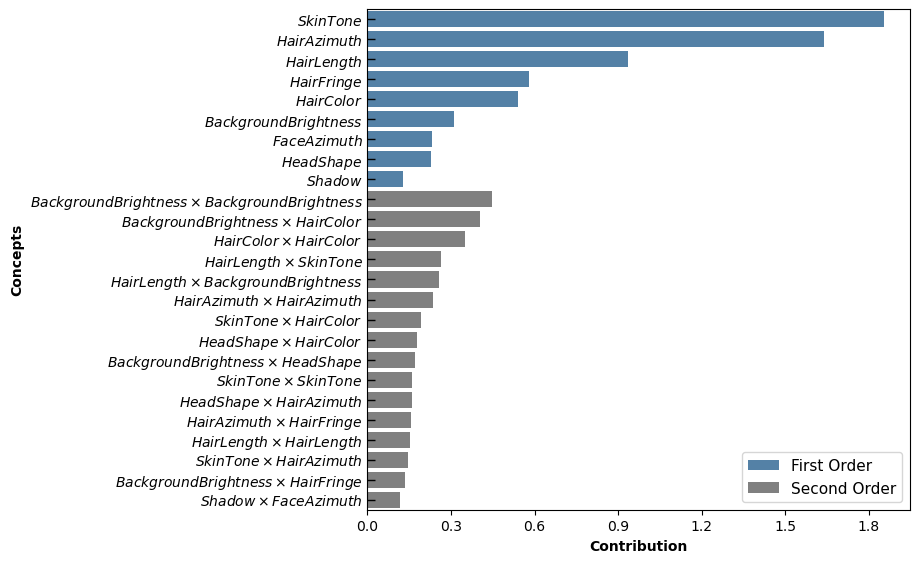

In [20]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(7, 6.5))
top = 25
num_2nd_order = top - num_concepts
colors = ['steelblue'] * num_concepts + ['grey'] * num_2nd_order
labels = ['First Order'] * num_concepts + ['Second Order'] * num_2nd_order
sns.barplot(x='contribution', y='concept', data=coeff_df.iloc[:top], ax=ax, hue='order', hue_order=labels, palette=colors)
ax.tick_params(axis='y', labelsize=10, which='major', direction='in', length=6, width=1)
ax.set_xlabel('Contribution', fontsize=10, fontweight='bold')
ax.set_ylabel('Concepts', fontsize=10, fontweight='bold')
ax.xaxis.set_major_locator(plt.MaxNLocator(7))
ax.legend(loc='lower right', fontsize=11)

plt.savefig('figures/{}_taylor2_contributions.png'.format(data_name), dpi=300, bbox_inches='tight', format='png')
# plt.savefig('figures/{}_taylor2_contributions.pdf'.format(data_name), bbox_inches='tight', format='pdf')
# plt.show()

In [21]:
avg_hist_data_order1 = {c: w for c, w in zip(concept_names, concept_predictions)}

In [22]:
col_min_max = {}

for i in range(len(concept_names)):
  vals = concept_results[:, i]
  col_min_max[concept_names[i]] = (np.min(vals), np.max(vals))

def inverse_min_max_scaler(x, min_val, max_val):
  return (x + 1)/2 * (max_val - min_val) + min_val

In [23]:
NUM_FEATURES = concept_results.shape[1]
SINGLE_FEATURES = np.split(concept_results, NUM_FEATURES, axis=1)
UNIQUE_FEATURES = [np.unique(x, axis=0) for x in SINGLE_FEATURES]

SINGLE_FEATURES_ORIGINAL = {}
UNIQUE_FEATURES_ORIGINAL = {}
for i, col in enumerate(concept_names):
  min_val, max_val = col_min_max[col]
  UNIQUE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(UNIQUE_FEATURES[i][:, 0], min_val, max_val)
  SINGLE_FEATURES_ORIGINAL[col] = inverse_min_max_scaler(SINGLE_FEATURES[i][:, 0], min_val, max_val)

In [24]:
ALL_INDICES = {}

for i, col in enumerate(concept_names):
  x_i = concept_results[:, i]
  ALL_INDICES[col] = np.searchsorted(UNIQUE_FEATURES[i][:, 0], x_i, 'left')

MEAN_PRED = {}
for col in concept_names:
  MEAN_PRED[col] =  np.mean([avg_hist_data_order1[col][i] for i in ALL_INDICES[col]])

print(MEAN_PRED)

{'dim_0': 0.0060634767, 'dim_1': -0.0022872896, 'dim_3': -0.02196686, 'dim_4': -0.0015413775, 'dim_5': 0.0114589315, 'dim_6': -0.0011296327, 'dim_7': 0.016768109, 'dim_8': 0.0006959485, 'dim_9': 0.010502543}


In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def shade_by_density_blocks(hist_data, num_rows, num_cols,
                            n_blocks=5, color=[0.9, 0.5, 0.5],
                            feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  min_y = np.min([np.min(a[1]) for a in hist_data_pairs])
  max_y = np.max([np.max(a[1]) for a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.01 * min_max_dif
  max_y = max_y + 0.01 * min_max_dif

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use]

  for i, (name, pred) in enumerate(hist_data_pairs):
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    single_feature_data = SINGLE_FEATURES_ORIGINAL[name]
    ax = plt.subplot(num_rows, num_cols, i+1)
    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)
    x_n_blocks = min(n_blocks, len(unique_x_data))

    segments = (max_x - min_x) / x_n_blocks
    density = np.histogram(single_feature_data, bins=x_n_blocks)
    normed_density = density[0] / np.max(density[0])
    rect_params = []
    for p in range(x_n_blocks):
      start_x = min_x + segments * p
      end_x = min_x + segments * (p + 1)
      d = min(1.0, 0.01 + normed_density[p])
      rect_params.append((d, start_x, end_x))

    for param in rect_params:
      alpha, start_x, end_x = param
      rect = patches.Rectangle((start_x, min_y - 1), end_x - start_x,
                               max_y - min_y + 1, linewidth=0.01,
                              edgecolor=color, facecolor=color, alpha=alpha)
      ax.add_patch(rect)

In [26]:
WEIGHTS = dict(zip(concept_names, order1))

In [27]:
def plot_all_hist(hist_data, num_rows, num_cols,  color_base,
                  linewidth=3.0, min_y=None, max_y=None, alpha=1.0,
                  feature_to_use=None):
  hist_data_pairs = list(hist_data.items())
  hist_data_pairs.sort(key=lambda x: x[0])
  if min_y is None:
    min_y = np.min([np.min(a) for _, a in hist_data_pairs])
  if max_y is None:
    max_y = np.max([np.max(a) for _, a in hist_data_pairs])
  min_max_dif = max_y - min_y
  min_y = min_y - 0.001 * min_max_dif
  max_y = max_y + 0.001 * min_max_dif
  col_mapping = COL_NAMES[data_name]

  total_mean_bias = 0

  if feature_to_use:
    hist_data_pairs = [v for v in hist_data_pairs if v[0] in feature_to_use]

  for i, (name, pred) in enumerate(hist_data_pairs):
    mean_pred = MEAN_PRED[name] #np.mean(pred)
    total_mean_bias += mean_pred
    unique_x_data = UNIQUE_FEATURES_ORIGINAL[name]
    weight_x = WEIGHTS[name]
    plt.subplot(num_rows, num_cols, i+1)
    
    cut = min(len(unique_x_data), len(pred))
    unique_x_data = unique_x_data[:cut]
    pred = pred[:cut]
    n_bins = 50
    pred_new = np.zeros(len(pred))
    bin_size = len(pred) // n_bins
    bin_values = np.zeros(n_bins)
    for j in range(n_bins):
      start = j * bin_size
      end = (j + 1) * bin_size
      pred_new[start:end] = np.mean(pred[start:end])
      bin_values[j] = np.mean(pred[start:end])

    # find the x values of the second highest of pred_new
    max_index = np.sort(bin_values)[-5]
    max_x1 = unique_x_data[np.argmax(max_index)]
    max_x2 = unique_x_data[np.argmax(max_index)]
    print(concept_names[i], max_x1, max_x2)

    plt.plot(unique_x_data, pred_new - mean_pred, color=color_base,
              linewidth=linewidth, alpha=alpha)
    plt.xticks(fontsize='x-large')
    plt.tick_params(axis="x",direction="inout", pad=2)
    plt.axhline(0, color='black', linewidth=2.0, linestyle='--', alpha=0.3)


    plt.ylim(-0.5, 0.5)
    plt.yticks(fontsize='x-large')

    min_x = np.min(unique_x_data)
    max_x = np.max(unique_x_data)

    plt.xlim(min_x, max_x)
    if i % num_cols == 0:
      plt.ylabel('Female Prediction Contribution', fontsize='x-large')
    plt.xlabel(col_mapping[name], fontsize='x-large', labelpad=1)
  return min_y, max_y

In [28]:
COLORS = [[0.9, 0.4, 0.5], [0.5, 0.9, 0.4], [0.4, 0.5, 0.9], [0.9, 0.5, 0.9]]
NUM_COLS = 3 #@param {'type': 'integer'}
N_BLOCKS = 25 #@param
NUM_FEATURES = len(concept_names)

MIN_Y = None
MAX_Y = None

dim_0 -18.64735 -18.64735
dim_1 -10.768743 -10.768743
dim_3 -17.016811 -17.016811
dim_4 -17.164255 -17.164255
dim_5 -14.604446 -14.604446
dim_6 -13.941593 -13.941593
dim_7 -18.107283 -18.107283
dim_8 -15.966438 -15.966438
dim_9 -13.806412 -13.806412


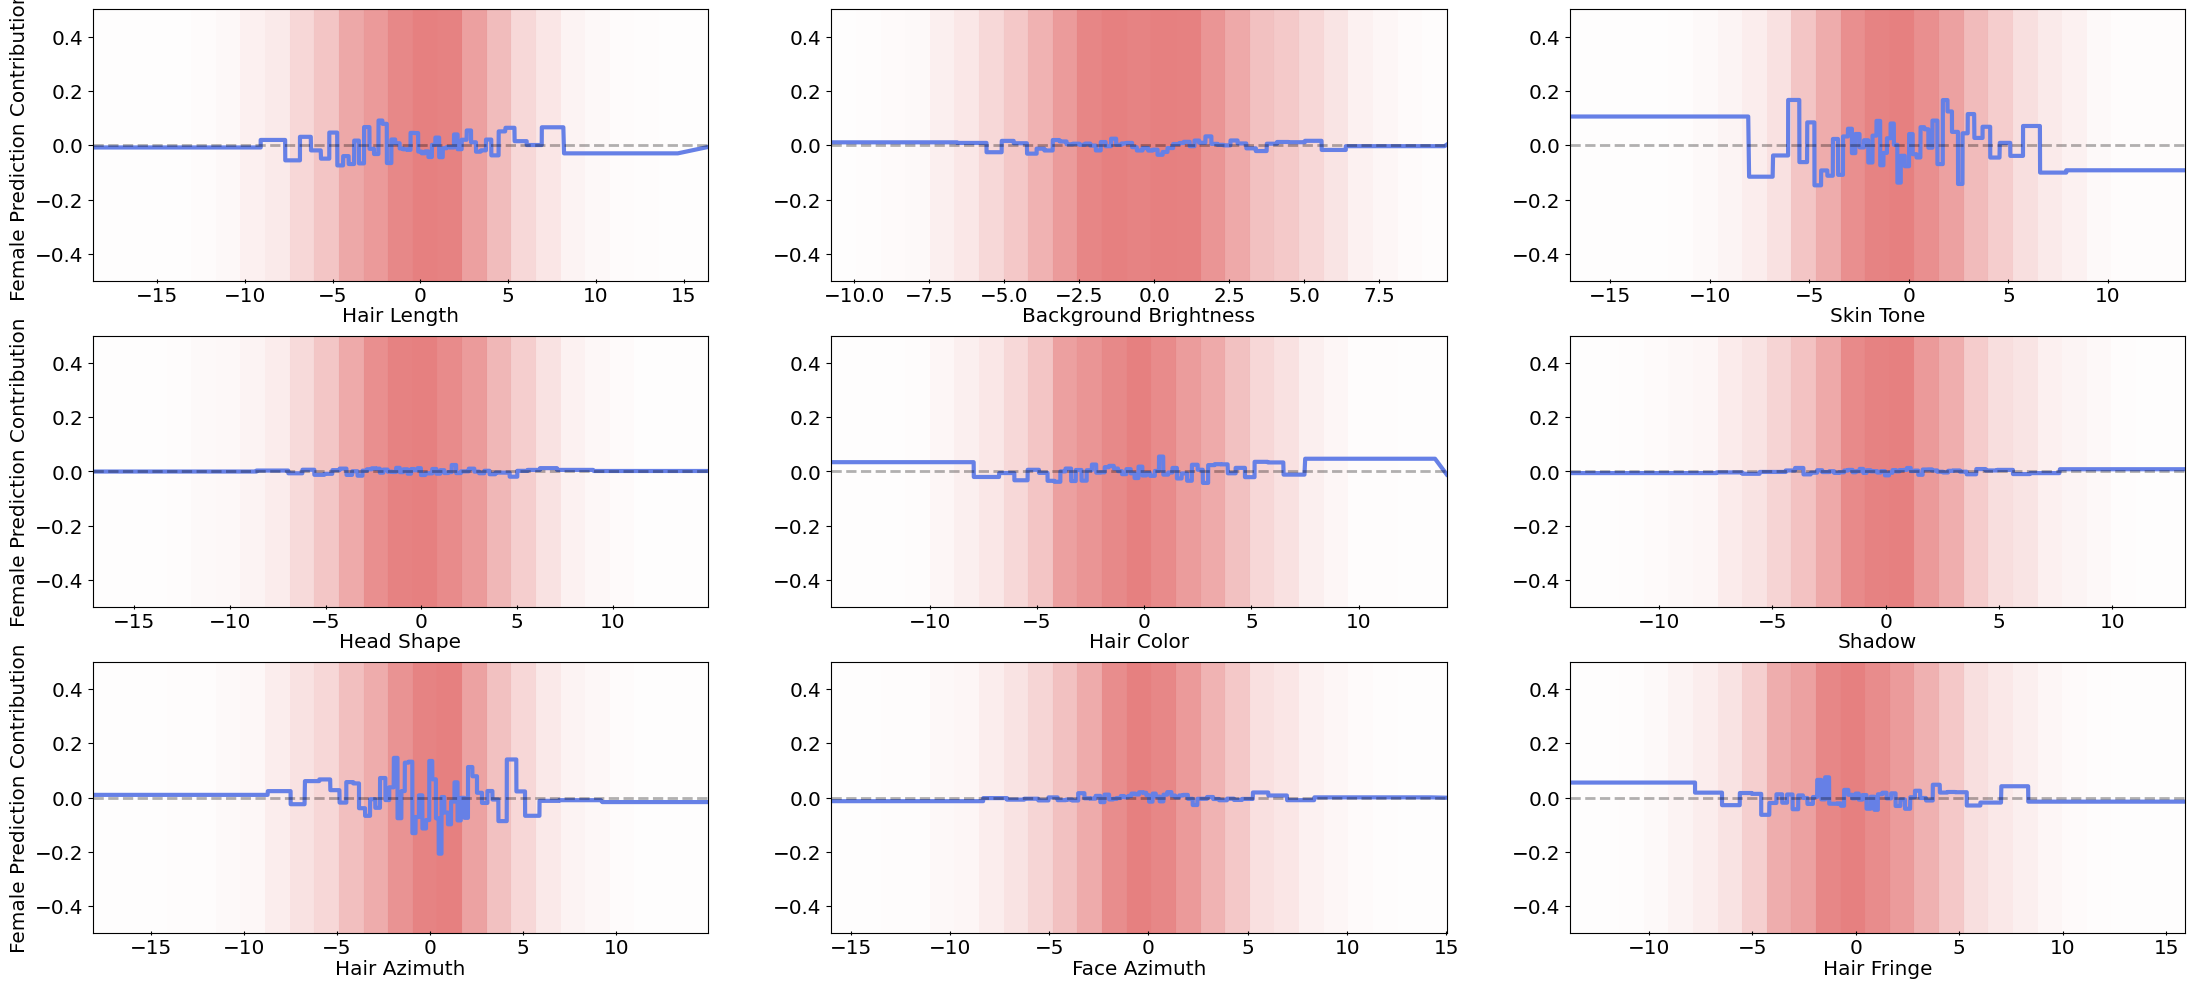

In [29]:
NUM_ROWS = int(np.ceil(NUM_FEATURES / NUM_COLS))
fig = plt.figure(num=None, figsize=(NUM_COLS * 9, NUM_ROWS * 4),
                 facecolor='w', edgecolor='k')

MIN_Y, MAX_Y = plot_all_hist(avg_hist_data_order1, NUM_ROWS, NUM_COLS, COLORS[2], feature_to_use=concept_names)
shade_by_density_blocks(avg_hist_data_order1, NUM_ROWS, NUM_COLS, n_blocks=N_BLOCKS, feature_to_use=concept_names)
plt.savefig('figures/{}_shape_functions.png'.format(data_name), dpi=300, bbox_inches='tight', format='png')
# plt.savefig('figures/{}_shape_functions.pdf'.format(data_name), bbox_inches='tight', format='pdf')
plt.show()